## 지그재그의 데이터분석 팀에 오신 것을 환영합니다!



<img src ="https://i.imgur.com/9zb1Cdh.jpg" width=700>

안녕하세요! [지그재그](https://zigzag.kr/) 데이터분석팀에 오신 것을 환영합니다.

지그재그는 여성 패션 쇼핑몰들의 상품 정보를 통합적으로 제공하는 플랫폼으로 개인 취향 알고리즘을 통해 적절한 제품을 추천하여 유저 경험을 높이고 있습니다. 지그재그는 2015년 6월 ‘내 스타일의 쇼핑몰을 편하게 북마크 해보자’라는 작은 아이디어에서 시작했습니다. 서비스가 출시되고 3년이 지난 지금, 지그재그에 입점한 2,700여 개의 온라인 쇼핑몰들에서는 하루에 10,000여 개의 패션 아이템이 업데이트되며 한 달에 200만 명이 넘는 사용자들이 방문해 자신이 좋아하는 상품을 실시간으로 발견하고 있습니다. 런칭 2년 반 만에 1,000만 앱 다운로드를 돌파하며 대한민국 여성의 쇼핑 필수 앱으로 자리 잡았습니다.


<img src = "https://i.imgur.com/chOEQhY.jpg" width=250>

 오늘 이 쥬피터 노트북을 받은 수강생분들께서는 지그재그의 일일 데이터 분석가(Data Analyst)로서 일을 할 것입니다. 지그재그의 하루 동안의 로그 데이터를 바탕으로 매출 분석 등 기본적인 데이터 탐색을 할 예정입니다. 일반적으로 매출 또는 핵심 지표에 영향을 미치는 요인에 대한 가설을 세우고 이를 데이터로 검증하는 일이 일반적인 데이터 분석이지만, 때로는 가설 없이 데이터 그 자체를 이해하는 것부터 출발하여 역으로 핵심 지표 또는 매출 등을 개선하기 위한 아이디어를 얻을 수도 있습니다. 이러한 데이터 자체를 이해하는 과정을 탐색적 자료 분석이라고 합니다. 여러분들은 6월 11일에 활동한 고객 정보, 쇼핑몰 정보, 거래 정보, 상품 정보, 그리고 고객의 행동 정보를 이해하고 분석하여 다른 팀들과 정보를 공유하게 될 것입니다.


---

In [1]:
# 필요 라이브러리 import
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # 시각화 결과를 선명하게 해줌

import warnings
warnings.filterwarnings(action='ignore')

import sqlite3 # DB를 다루는 라이브러리

pd.set_option('display.max_rows', 500) # 데이터 프레임의 최대 row 500개 고정
pd.set_option('display.max_columns', 500) # 데이터 프레임의 최대 column 500개 고정

##### **1. data 폴더의 zigzag_DB.db에 연결한 뒤 데이터베이스 스키마를 출력해주세요. 그 다음,  order 테이블을 불러와주세요.**

zigzag 데이터 테이블들을 모두 zigzag_DB.db 파일에 저장해두었습니다. 저번 주 수업자료를 참고해 database를 조회하고 그 중, order 테이블을 불러와주세요.

In [2]:
connect = sqlite3.connect('./zigzag_DB.db')
query = "SELECT * FROM sqlite_master"

# 사용할 DB Table 목록
schema = pd.read_sql(query, connect)
for i in schema['sql']:
    print(i)

CREATE TABLE "order" (
"timestamp" TEXT,
  "user_id" TEXT,
  "goods_id" INTEGER,
  "shop_id" INTEGER,
  "price" INTEGER
)
CREATE TABLE "good" (
"goods_id" INTEGER,
  "timestamp" TEXT,
  "shop_id" INTEGER,
  "category" TEXT,
  "price" INTEGER,
  "image_type" TEXT,
  "image_width" INTEGER,
  "image_height" INTEGER
)
CREATE TABLE "shop" (
"shop_id" INTEGER,
  "name" TEXT,
  "category" TEXT,
  "age" TEXT,
  "style" TEXT
)
CREATE TABLE "log" (
"timestamp" TEXT,
  "user_id" TEXT,
  "event_origin" TEXT,
  "event_name" TEXT,
  "event_goods_id" REAL,
  "event_shop_id" REAL
)
CREATE TABLE "user" (
"user_id" TEXT,
  "os" TEXT,
  "age" INTEGER
)


In [3]:
# order 테이블 loading
query = "SELECT * FROM 'order'"

order = pd.read_sql(query, connect)
order.head()

,timestamp,user_id,goods_id,shop_id,price
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000
1,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500
2,2018-06-11 00:04:06.364,EyGjKYtSqZgqJ1ddKCtH5XwGirTyOH2P,646,14,22000
3,2018-06-11 00:04:17.258,KQBGi33Zxh5Dgu0WEkOkjN0YqTT_wxC3,5901,46,29800
4,2018-06-11 00:05:26.010,lq1Je3voA3a0MouSFba3629lKCvweI24,5572,89,29000


##### **2. order 테이블을 이용해 지그재그의 당일 매출 상위 10개 쇼핑몰을 구해주세요.**

order 테이블을 이용해 지그재그를 통해 이루어진 6월 11일의 쇼핑몰별 매출 정보를 피벗 테이블을 이용하여 구해주세요. 

In [4]:
table = pd.pivot_table(order,
                       values = 'price',
                       index = 'shop_id',
                       aggfunc = 'sum')

table.sort_values(( 'price'), ascending=False).head(10)

,price
shop_id,
22,1365200
14,872000
63,710700
32,707900
126,669400
6,655900
11,653000
60,558300
19,518400


##### **3. 판매 건수를 포함하여 피벗테이블을 만들어주세요. 또한, 상위 10개 쇼핑몰의 매출을 막대그래프로 보여주세요.**

매출과 결제 건수를 함께 볼 수 있는 피벗테이블을 작성해주세요. 그리고, 그 결과를 막대그래프로 시각화하여 보여주세요.

In [5]:
table = pd.pivot_table(order,
                       values = 'price',
                       index = 'shop_id',
                       aggfunc = ['sum', 'count'])

table.columns = ['sum', 'count']
table = table.sort_values('sum', ascending=False)

table_top10 = table.head(10)
table_top10

,sum,count
shop_id,,
22,1365200,99
14,872000,30
63,710700,27
32,707900,37
126,669400,39
6,655900,24
11,653000,19
60,558300,23
19,518400,19


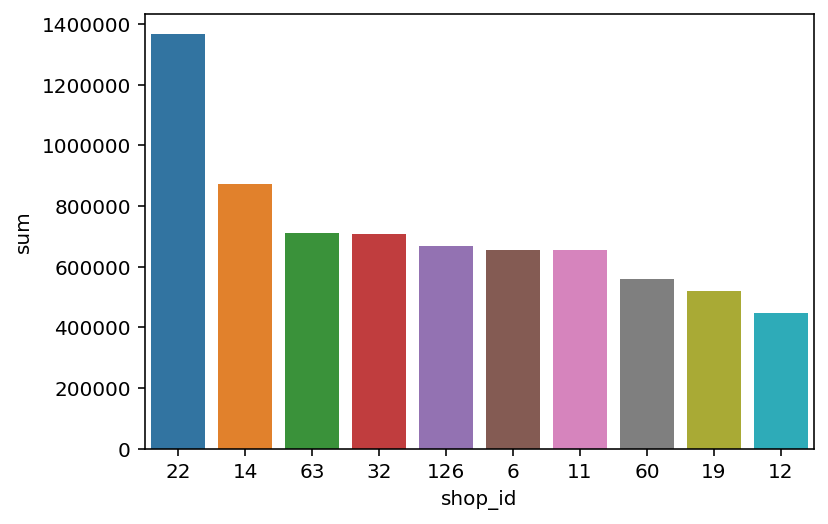

In [6]:
sns.barplot(data=table_top10, x=table_top10.index, y='sum', order=table_top10.index)

##### **4. 시간대별 지그재그 매출을 구하려고 합니다. lineplot을 이용하여 6월 11일의 시간대별 매출을 시각화 해주세요.**

지그재그 이용자들의 구매 패턴을 알아보려고 합니다. timestamp를 to_datetime을 이용하여 datetime 자료형으로 만든 뒤, 이를 이용하여 시간대별 총 매출량을 구해주세요.

In [7]:
import matplotlib as mpl

sns.set_style('whitegrid')

mpl.rc('font', family='Malgun Gothic')  
mpl.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [8]:
# 'timestamp'의 type을 datetime으로 변경
order['timestamp'] = pd.to_datetime(order['timestamp'])
order.dtypes

timestamp    datetime64[ns]
user_id              object
goods_id              int64
shop_id               int64
price                 int64
dtype: object

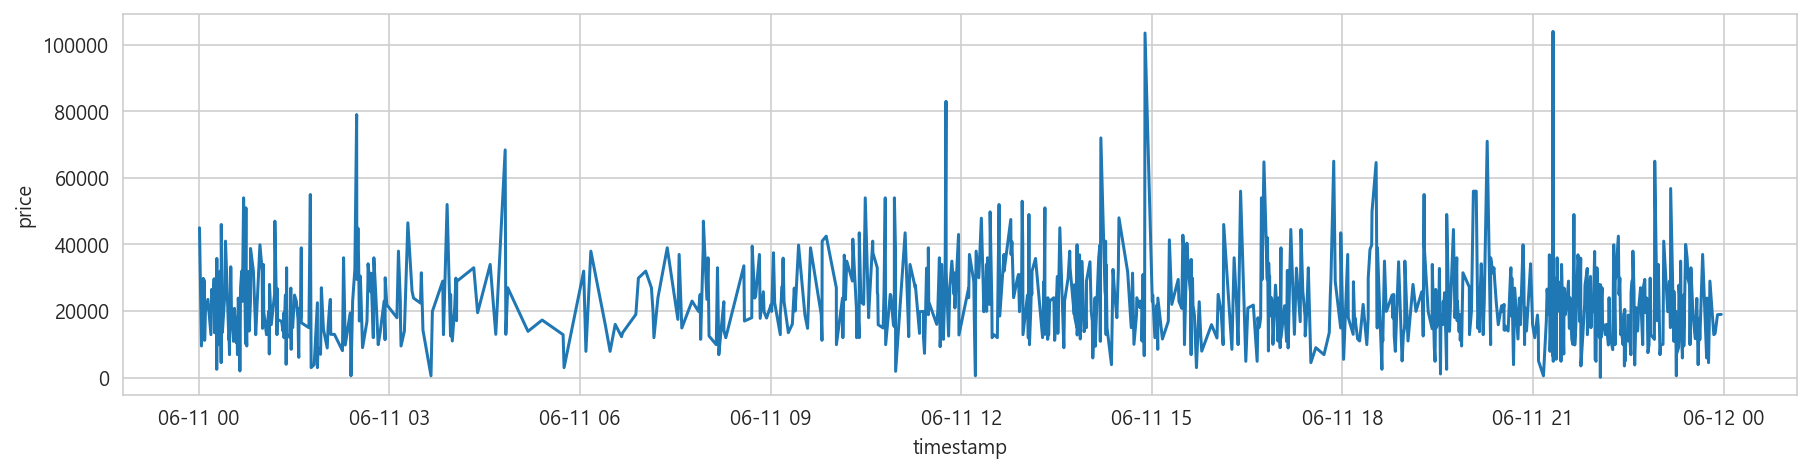

In [9]:
# 6.11의 매출량 시각화
plt.figure(figsize=[15,3.5])
sns.lineplot(x='timestamp', y='price', data=order)

##### **5. 위의 시각화를 구간화(binning) 작업을 거쳐 보기 좋은 형태로 만들어주세요.**

위의 시각화는 적절하지 못한 시각화입니다. 정확하게는 x시 00분 ~ x시 59분 까지의 매출을 시간대별로 모두 합하는 binning 과정을 거친 뒤 시각화를 진행해야 원하는 결과를 얻을 수 있습니다.

order 테이블에 로그의 발생 시간을 나타내는 hour 칼럼을 추가한 뒤, pivot_table을 이용하여 시간대별 매출을 구해주세요. 그리고, 이를 이용해 아래와 같은 그래프를 만들어 주세요.

*lineplot을 사용하는 경우*
![](https://i.imgur.com/sGVLJKi.png)

*pointplot을 사용하는 경우*
![](https://i.imgur.com/hYuKVqE.png)

In [10]:
order['hour'] = order['timestamp'].dt.hour
table = order.pivot_table(values='price',
                          index='hour',
                          aggfunc='sum')

table.head()

,price
hour,
0,1479210
1,990300
2,787830
3,467650
4,304800


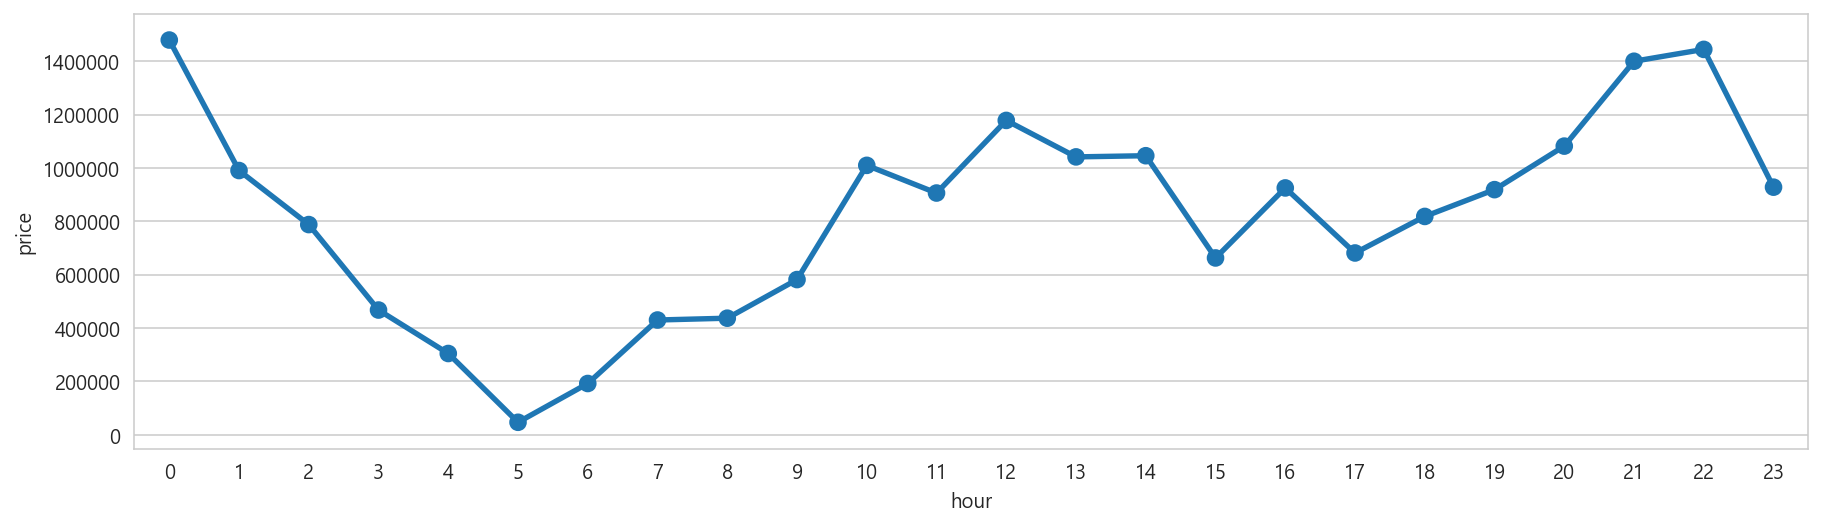

In [11]:
# 시간 단위별 매출 시각화
plt.figure(figsize=[15,4])
sns.pointplot(data=table, x=table.index, y='price')
plt.savefig('image.png')

##### **6 . user 테이블을 불러와 order 테이블과 병합해주세요.**

user 테이블에는 고객의 고유 아이디를 나타내는 user_id, 그리고 접속 기기정보를 나타내는 os, 그리고 나이정보 age가 있습니다. 이를 이용해 top 10 쇼핑몰 매출이 어떤 연령층에서 발생했는지 분석하고자 합니다. 데이터베이스에서 user 테이블을 불러온 뒤, order 테이블과 병합해주세요.

In [12]:
query = "SELECT * FROM 'user'"
user = pd.read_sql(query, connect)
print(user.shape)
user.head()

(10000, 3)


,user_id,os,age
0,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,And,41
1,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,iOS,31
2,-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN,iOS,16
3,-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1,And,41
4,-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k,And,42


In [13]:
merged = order.merge(user, on='user_id')
merged.head()

,timestamp,user_id,goods_id,shop_id,price,hour,os,age
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39
1,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500,0,And,17
2,2018-06-11 00:04:06.364,EyGjKYtSqZgqJ1ddKCtH5XwGirTyOH2P,646,14,22000,0,And,-1
3,2018-06-11 00:04:17.258,KQBGi33Zxh5Dgu0WEkOkjN0YqTT_wxC3,5901,46,29800,0,And,34
4,2018-06-11 00:05:26.010,lq1Je3voA3a0MouSFba3629lKCvweI24,5572,89,29000,0,And,17


##### **7. 매출 Top 10 쇼핑몰 구매자들의 연령대를 쇼핑몰별로 시각화하여 보여주세요.**

위의 병합된 테이블을 이용하여, 당일 매출 Top 10 쇼핑몰에서 구매를 한 고객들의 연령대 분포를 시각화로 표현하고자 합니다. 이를 이용해 쇼핑몰이 설정한 타겟 연령대와 실제 구매층이 일치하는지를 비교해보고자 합니다.

In [14]:
top10_index = table_top10.index
# age의 값이 -1인 제외
merged_top10 = merged[(merged['shop_id'].isin(top10_index)) & (merged['age'] != -1)]

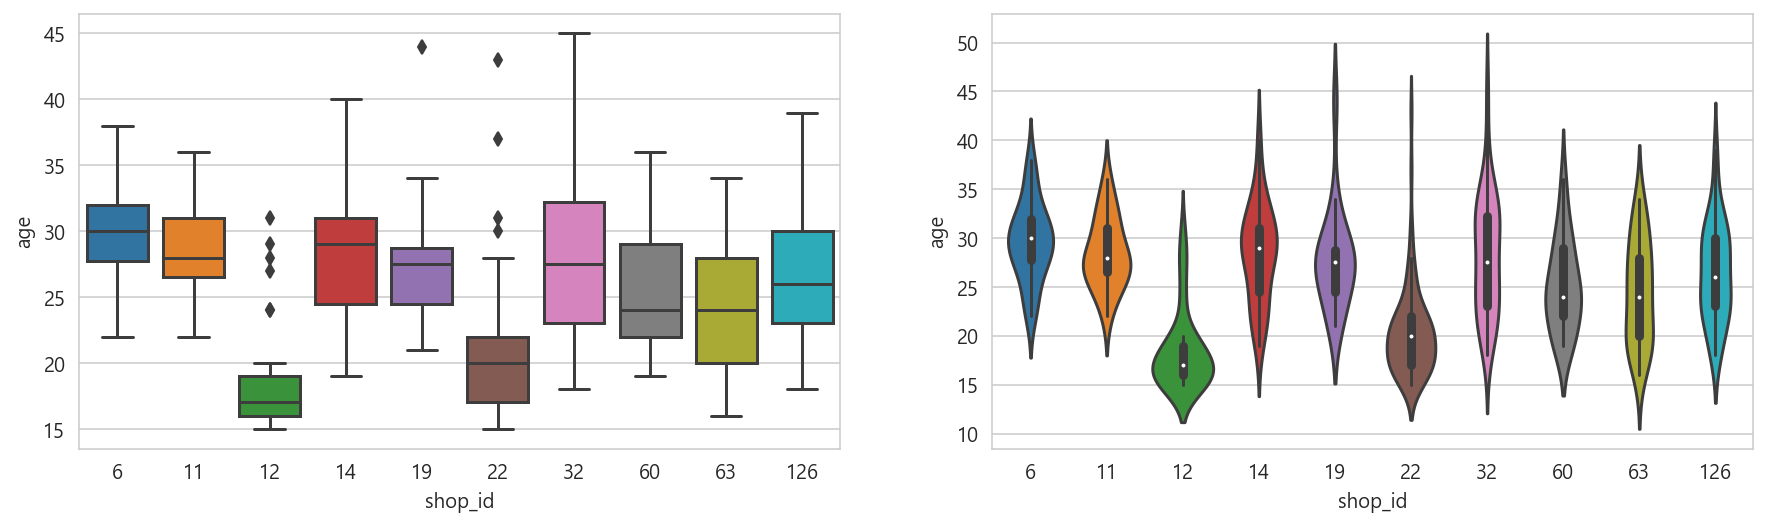

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches([15,4])

sns.boxplot(data = merged_top10, x='shop_id', y='age', ax=ax1)
sns.violinplot(data = merged_top10, x='shop_id', y='age', ax=ax2)

fig.savefig('figure.png', dpi=400)

##### **8. user 테이블에 연령대를 나타내는 칼럼을 만들어주세요. 그리고 쇼핑몰이 설정한 타겟 연령대와 실제로 구매를 한 고객의 연령과 일치하는지를 검증해주세요.**

수행해야 할 작업은 총 3단계입니다.

    1. 실제 나이를 바탕으로 user 테이블에 연령대 칼럼을 만들기
    2. shop 테이블을 불러와 user, order 테이블과 병합하기
    3. 쇼핑몰의 타겟 연령대와 해당 쇼핑몰에서의 결제를 한 고객의 연령대를 비교하기

In [16]:
def make_generation(age):
    if age == -1:
        return '미입력'
    elif age // 10 >= 4:
        return "30대 후반"
    elif age // 10 == 1:
        return "10대"
    elif age % 10 < 3:
        return str(age // 10 * 10) + f"대 초반"
    elif age % 10 <= 6:
        return str(age // 10 * 10) + f"대 중반"
    else:
        return str(age // 10 * 10) + f"대 후반"

    
print(make_generation(10))
print(make_generation(23))
print(make_generation(29))
print(make_generation(32))
print(make_generation(35))
print(make_generation(40))

10대
20대 중반
20대 후반
30대 초반
30대 중반
30대 후반


In [17]:
user["연령대"] = user['age'].map(make_generation)
user.head()

,user_id,os,age,연령대
0,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,And,41,30대 후반
1,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,iOS,31,30대 초반
2,-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN,iOS,16,10대
3,-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1,And,41,30대 후반
4,-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k,And,42,30대 후반


shop 테이블을 DB에서 불러와 주세요. 그 다음, user, order 테이블과 병합해주세요.

In [18]:
query = "SELECT * FROM 'shop'"
shop = pd.read_sql(query, connect, index_col='shop_id')
print(shop.shape)
shop.head()

(200, 4)


,name,category,age,style
shop_id,,,,
1,Edna,의류,20대 중반/20대 후반/30대 초반,모던시크/러블리
2,Pam,의류,20대 중반/20대 후반/30대 초반,러블리/심플베이직
3,Carolyn,의류,20대 중반/20대 후반/30대 초반,모던시크/심플베이직
4,Joan,의류,30대 초반/30대 중반,미시스타일/유니크
5,Florene,의류,20대 중반/20대 후반/30대 초반,심플베이직/헐리웃스타일


In [19]:
merged_table = (order.merge(user, on='user_id').merge(shop, on='shop_id'))

merged_table.head()

,timestamp,user_id,goods_id,shop_id,price,hour,os,age_x,연령대,name,category,age_y,style
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,And,32,30대 초반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
2,2018-06-11 12:56:27.867,MnvhmV0tA89bN9TLXgRTbLza689bTkT9,5513,38,31000,12,And,37,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
3,2018-06-11 22:57:11.582,3Vo9NP0qU_176pgbqk6Cu-CY7kpJ2-WB,7026,38,17100,22,iOS,34,30대 중반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
4,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500,0,And,17,10대,Rachel,의류,10대/20대 초반,러블리/심플베이직


병합한 테이블을 이용하여 '거래연령 일치여부' 칼럼을 아래의 칼럼을 이용하여 만들어 주세요. 각 열이 아닌 각 행에 함수를 적용할 때는 `apply(function, axis=1)`을 이용해야 합니다.

In [20]:
def check_generation(row):
    if row['category'] == '의류' and row['연령대'] == '미입력':
        return True
    else:
        return row['연령대'] in str(row['age_y'])

In [21]:
merged_table['거래연령 일치여부'] = merged_table.apply(check_generation, axis=1)
merged_table.head(2)

,timestamp,user_id,goods_id,shop_id,price,hour,os,age_x,연령대,name,category,age_y,style,거래연령 일치여부
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,False
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,And,32,30대 초반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True


In [22]:
table = merged_table.pivot_table(values='거래연령 일치여부',
                                 index='shop_id',
                                 aggfunc=['mean', 'count'])

table.head()

,mean,count
,거래연령 일치여부,거래연령 일치여부
shop_id,,
1,0.666667,3
2,0.937500,16
3,0.400000,5
4,1.000000,1
5,0.000000,1


In [23]:
# Top10 쇼핑몰
table[table.index.isin(top10_index)]

,mean,count
,거래연령 일치여부,거래연령 일치여부
shop_id,,
6,0.750000,24
11,0.684211,19
12,0.857143,42
14,0.566667,30
19,0.789474,19
22,0.929293,99
32,0.540541,37
60,0.695652,23


##### **9. 쇼핑몰의 스타일 태그를 정리해주세요.**

쇼핑몰별로 제품군의 스타일을 나타낼 수 있는 태그를 가지고 있습니다. 이 태그는 다음의 리스트에 정리되어 있습니다.

In [24]:
style_list = ['페미닌', '모던시크', '심플베이직', '러블리', '유니크', '미시스타일', '캠퍼스룩', '빈티지', '섹시글램', '스쿨룩', '로맨틱', '오피스룩',
              '럭셔리', '헐리웃스타일', '심플시크', '키치', '펑키', '큐티', '볼드&에스닉' ]

In [25]:
for style in style_list:
    shop[f"{style}"] = shop['style'].str.contains(style)

In [26]:
shop.head()

,name,category,age,style,페미닌,모던시크,심플베이직,러블리,유니크,미시스타일,캠퍼스룩,빈티지,섹시글램,스쿨룩,로맨틱,오피스룩,럭셔리,헐리웃스타일,심플시크,키치,펑키,큐티,볼드&에스닉
shop_id,,,,,,,,,,,,,,,,,,,,,,,
1,Edna,의류,20대 중반/20대 후반/30대 초반,모던시크/러블리,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Pam,의류,20대 중반/20대 후반/30대 초반,러블리/심플베이직,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Carolyn,의류,20대 중반/20대 후반/30대 초반,모던시크/심플베이직,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,Joan,의류,30대 초반/30대 중반,미시스타일/유니크,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5,Florene,의류,20대 중반/20대 후반/30대 초반,심플베이직/헐리웃스타일,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


##### **10. 스타일별 실제 구매 기록을 바탕으로 가장 구매가 많이 일어난 스타일 키워드를 찾아주세요. 또한, 매출이 가장 많은 3가지 스타일의 구매 연령대 분포를 그려주세요.**


위에서 전처리한 스타일을 이용하기 위해 order, shop, user 테이블을 다시 테이블을 병합하도록 하겠습니다.

In [27]:
merged = (order.merge(shop, on='shop_id').merge(user, on='user_id'))
print(merged.shape)
merged.head(3)

(867, 32)


,timestamp,user_id,goods_id,shop_id,price,hour,name,category,age_x,style,페미닌,모던시크,심플베이직,러블리,유니크,미시스타일,캠퍼스룩,빈티지,섹시글램,스쿨룩,로맨틱,오피스룩,럭셔리,헐리웃스타일,심플시크,키치,펑키,큐티,볼드&에스닉,os,age_y,연령대
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,iOS,39,30대 후반
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,And,32,30대 초반
2,2018-06-11 12:56:27.867,MnvhmV0tA89bN9TLXgRTbLza689bTkT9,5513,38,31000,12,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,And,37,30대 후반


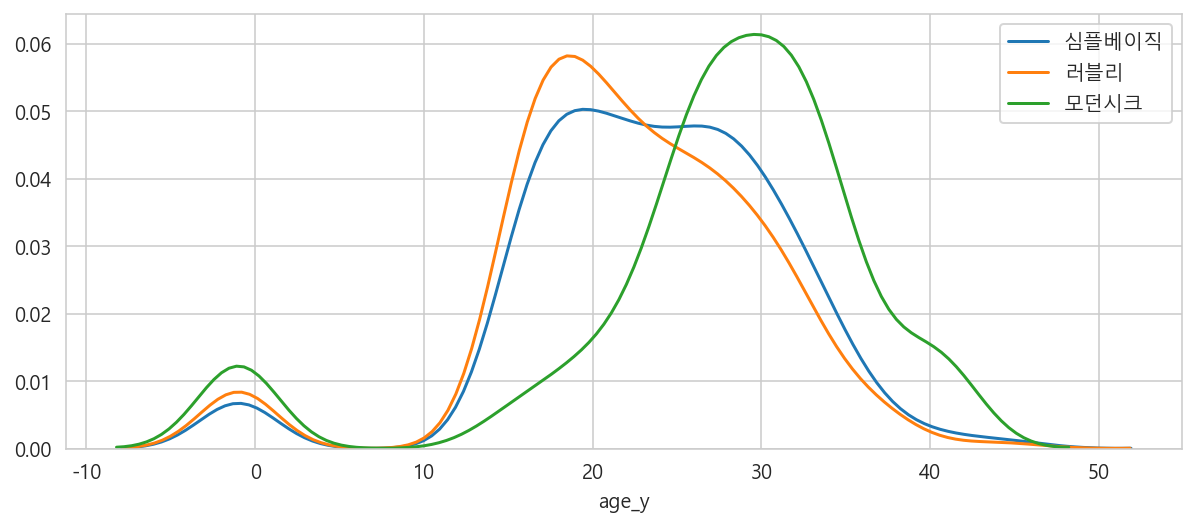

In [28]:
plt.figure(figsize=[10,4])

sns.distplot(merged.loc[merged['심플베이직'] == True, 'age_y'], label = '심플베이직', hist=False)
sns.distplot(merged.loc[merged['러블리'] == True, 'age_y'], label = '러블리', hist=False)
sns.distplot(merged.loc[merged['모던시크'] == True, 'age_y'], label = '모던시크', hist=False)

plt.savefig('dist.png', dpi=400)

### 여기서 부터는 로그 데이터분석에 관한 내용입니다.



#### 아래의 내용은 로그 데이터분석의 핵심 수치들을 구하는 것과 이를 위한 전처리로 이루어져 있습니다. 핵심 수치들은 다음과 같습니다.

1. page duration
    - 사용자가 앱의 한 page당 체류하는 시간입니다. 
<br/>
2. session
    - 앱을 실행하는 단위로서, 세션은 사용자가 앱을 실행한 후부터 그 실행을 마칠 때까지의 일련의 과정을 포함합니다.
<br/>
3. 체류 시간
    - 사용자가 page, session 혹은 특정 기준동안 머무르는 시간입니다.<br/>

`[assignment]`에서는 각 용어를 "log duration", "cycle", "잔존 시간"이란 표현을 사용하였지만, 앞으로는 로그 분석에서 보편적으로 사용하는 용어인 위의 용어들로 사용하겠습니다. 




##### **10. DB에서 로그 데이터를 불러와주신 다음 timestamp컬럼을 datetime 형식으로 변환해 주세요.**
그리고 user id를 보기 쉽게 간단한 자연수 형태로 변환해주세요.

In [29]:
query = "SELECT * FROM 'log'"

data_logs = pd.read_sql(query, connect)
print(data_logs.shape)
data_logs.head()

(105815, 6)


,timestamp,user_id,event_origin,event_name,event_goods_id,event_shop_id
0,2018-06-11 00:00:00.213,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,shops_ranking,app_page_view,NaN,NaN
1,2018-06-11 00:00:00.810,lwFZ77v_ygk0uU40t1ud3l30EZ6sE2R3,shops_bookmark,app_page_view,NaN,NaN
2,2018-06-11 00:00:00.956,mR-bO6hC9g-m8ERXMRQZaRwJFvzNNdd8,goods_search_result/로브,app_page_view,NaN,NaN
3,2018-06-11 00:00:01.084,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,shops_bookmark,app_page_view,NaN,NaN
4,2018-06-11 00:00:01.561,Yjny5AchUWLiuv4kdeq50COF-S8OFXPd,shops_bookmark,app_page_view,NaN,NaN


In [30]:
data_logs['timestamp'] = pd.to_datetime(data_logs['timestamp'])

지그재그 로그 데이터의 명세는 다음과 같습니다.


- 컬럼 별 명세
        1. timestamp : 이벤트 발생 시간 (한국 시간 기준)
        2. user_id : 이용자 고유 식별자
        3. event_origin : 이벤트가 발생한 앱 위치
            - event_origin 값 별 의미
                a. goods_search_result : 특정 검색어의 상품 검색 결과
                    (Ex: goods_search_result/반팔티)
                b. shops_ranking : '쇼핑몰 랭킹' 영역
                c. shops_bookmark : '즐겨찾기' 영역
                d. category_search_result : 카테고리 검색 결과 
                    (Ex:category_search_result/상의)
                e. my_goods : '내 상품' 영역
                
        4. event_name : 발생한 이벤트 명
            - event_name 값 별 의미
                a. app_page_view : 앱 내 화면 이동
                b. enter_browser : 앱 내 클릭을 통해, 특정 웹페이지로 진입
                c. add_bookmark : 특정 쇼핑몰을 즐겨찾기 추가
                d. remove_bookmark : 특정 쇼핑몰을 즐겨찾기 제거
                e. add_my_goods : 특정 상품을 내 상품 추가
                f. remove_my_goods : 특정 상품을 내 상품 제거
                
        5. event_goods_id : 이벤트가 발생한 상품 고유 식별자
             - 상품 관련 이벤트가 아닌 경우, 공백
             
        6. event_shop_id : 이벤트가 발생한 쇼핑몰 고유 식별자
             - 쇼핑몰 관련 이벤트가 아닌 경우, 공백




In [31]:
user_id = user['user_id'].unique()
user_id

array(['--PYPMX8QWg0ioT5zfORmU-S5Lln0lot',
       '-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv',
       '-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN', ...,
       'zz-aNy7UWfvyrZxO4Fs4K5ewmqZVaMOs',
       'zznj-LHhddVvuzZmbZpw6MSylLO64982',
       'zzxBQ7i7mttX0cv1GqFuuMstg7keEkdV'], dtype=object)

In [32]:
# 연속된 자연수 지정
n_user_id = range(user['user_id'].size)
n_user_id

range(0, 10000)

In [33]:
# 기존의 id와 새로운 id를 짝짓기
id_zip = zip(user_id, n_user_id)
print(id_zip)

In [34]:
# 상위 5개 결과 확인
list(zip(user_id, n_user_id))[:5]

[('--PYPMX8QWg0ioT5zfORmU-S5Lln0lot', 0),
 ('-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv', 1),
 ('-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN', 2),
 ('-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1', 3),
 ('-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k', 4)]

In [35]:
# 새로운 id와 기존의 id가 대응된 딕셔너리 타입 변수를 생성
id_dict = dict(id_zip)
id_dict

{'--PYPMX8QWg0ioT5zfORmU-S5Lln0lot': 0,
 '-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv': 1,
 '-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN': 2,
 '-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1': 3,
 '-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k': 4,
 '-3fmY1WsLkYJwN_8lZQMmxZd6zJTAcT1': 5,
 '-3q-oynqxFEgSHUwX802hpmi1louyQNv': 6,
 '-428TMckUlhn6ptxN7gR2FGaSyXjSnaD': 7,
 '-4O8WnD8dT6nWho-4KbIm6TvnK4BmjX_': 8,
 '-4ltLPS55n6J2wSUCLxEZwxYdeW37cK5': 9,
 '-5BA0EwkyhGLCC8FxzvvDgyrZWYJM33I': 10,
 '-5Cwn2Fcx9j16QSM2-SLiaLMm0sS4E2I': 11,
 '-5o3lkvJctT3uURb5JWPVxe1VjqhyzAi': 12,
 '-622WUNWBtjX5VGKx8UnOtn2NVHD_NaB': 13,
 '-62U2A3KHjNZ2XXmOgQTSWEfPg1RRWWy': 14,
 '-63J8veARgGL3ulnRKblm4xhhwkvjKzG': 15,
 '-6UZWGgl3AAI7Df2sVWLX6oT6zP43zo0': 16,
 '-6jxyh56lSivkbLm3WNGRCmdyrdsBmNW': 17,
 '-71z4lG_D-eKnOmDCJlUaNvVcwd808yw': 18,
 '-75tFsDSoUwapUvwCUHTZiGTGkaSDleQ': 19,
 '-7SKUZkBmbG2ZMvJ0E0jmMDcd8PgmARb': 20,
 '-7uBbvfy4gff6mHV9XotjVO2YlCY2r8v': 21,
 '-8htVW7UIA8qRupSdCx-6PzIXLI_vk2p': 22,
 '-9qbSavSdufdw9JwmiWX1_URT2E2QxFZ': 23,
 '-Ae6T8G5uAZldwUEOTMR-KzG

In [36]:
# data_logs, order, user에 id_idct를 mapping하여 각 데이터 프레임에 
# 새로운 고객 id컬럼 생성
data_logs["n_user_id"] = data_logs['user_id'].map(id_dict)
order["n_user_id"] = order['user_id'].map(id_dict)
user["n_user_id"] = user['user_id'].map(id_dict)

data_logs[['user_id', 'n_user_id']].head()

,user_id,n_user_id
0,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,3314
1,lwFZ77v_ygk0uU40t1ud3l30EZ6sE2R3,7844
2,mR-bO6hC9g-m8ERXMRQZaRwJFvzNNdd8,7920
3,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,3314
4,Yjny5AchUWLiuv4kdeq50COF-S8OFXPd,5608


 ##### **12. 주문 데이터, 로그 데이터를 concat해주세요**
 
 주문기록은 user_event_log에 기록되지 않습니다. 이는 바로 아래에서 확인할 수 있습니다. 이를 확인하고 해당 데이터들을 concat해야 되는 이유를 살펴보겠습니다.

In [37]:
# 첫 row 출력
order.iloc[0]

timestamp          2018-06-11 00:00:43.032000
user_id      bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx
goods_id                                 1414
shop_id                                    38
price                                   45000
hour                                        0
n_user_id                                6241
Name: 0, dtype: object

In [40]:
# 중복되는 고객 목록(판다스의 merge 활용)
log_order_user = pd.merge(data_logs, order, on = 'user_id', how = 'inner')

user_duplicated = log_order_user['user_id'].unique()

print('중복되는 고객수입니다 :', len(user_duplicated) , end ='명\n')

중복되는 고객수입니다 : 742명


In [41]:
# data_logs의 columns을 기준으로 병합해야함
print(order.columns)
print(data_logs.columns)

Index(['timestamp', 'user_id', 'goods_id', 'shop_id', 'price', 'hour',
       'n_user_id'],
      dtype='object')
Index(['timestamp', 'user_id', 'event_origin', 'event_name', 'event_goods_id',
       'event_shop_id', 'n_user_id'],
      dtype='object')


In [43]:
order_copy = order.copy()
# 겹치는 유저만으로 data를 indexing
order_copy = order_copy[order_copy['user_id'].isin(user_duplicated)]

#  event_origin 컬럼에는 shop_id 컬럼을 저장
order_copy['event_origin'] = order_copy['shop_id']
#  event_name 컬럼에는 'purchase'를 저장
order_copy['event_name'] = 'purchase'
# event_goods_id 컬럼에는 good_id 컬럼
order_copy['event_goods_id'] = order_copy['goods_id']

# 사용할 columns
order_copy = order_copy[['timestamp', 'n_user_id', 'user_id','event_origin',
         'event_name', 'event_goods_id', 'price']]

order_copy.head()

,timestamp,n_user_id,user_id,event_origin,event_name,event_goods_id,price
0,2018-06-11 00:00:43.032,6241,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,38,purchase,1414,45000
1,2018-06-11 00:02:33.763,8899,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,12,purchase,1351,9500
4,2018-06-11 00:05:26.010,7832,lq1Je3voA3a0MouSFba3629lKCvweI24,89,purchase,5572,29000
5,2018-06-11 00:05:35.182,2745,GM0-EsJPHjkpteIpAQIwaCdUjU81lhW1,22,purchase,55,11200
6,2018-06-11 00:06:14.314,7800,lgvWxrv7r5RGklXSJqM2x6NUBZ5H-RQZ,22,purchase,2451,19800


In [44]:
# 위 내용을 log_order에 저장
log_order = pd.concat([data_logs, order_copy], sort = False)

log_order.shape

(106587, 8)

 log_order에 구매기록여부 컬럼인 purchase 컬럼을 만들어주세요.
 
 price컬럼을 이용해주세요. 
 
 출력 결과는 아래와 같습니다.
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_goods_id</th>
      <th>event_name</th>
      <th>event_origin</th>
      <th>event_shop_id</th>
      <th>n_user_id</th>
      <th>price</th>
      <th>timestamp</th>
      <th>user_id</th>
      <th>purchase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_ranking</td>
      <td>NaN</td>
      <td>3314</td>
      <td>NaN</td>
      <td>2018-06-11 00:00:00.213</td>
      <td>K1d8_t3-QIskaSkrx32oAFu856D8JmLo</td>
      <td>False</td>
    </tr>
    <tr>
      <th>1</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>7844</td>
      <td>NaN</td>
      <td>2018-06-11 00:00:00.810</td>
      <td>lwFZ77v_ygk0uU40t1ud3l30EZ6sE2R3</td>
      <td>False</td>
    </tr>
    <tr>
      <th>2</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>goods_search_result/로브</td>
      <td>NaN</td>
      <td>7920</td>
      <td>NaN</td>
      <td>2018-06-11 00:00:00.956</td>
      <td>mR-bO6hC9g-m8ERXMRQZaRwJFvzNNdd8</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>3314</td>
      <td>NaN</td>
      <td>2018-06-11 00:00:01.084</td>
      <td>K1d8_t3-QIskaSkrx32oAFu856D8JmLo</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>5608</td>
      <td>NaN</td>
      <td>2018-06-11 00:00:01.561</td>
      <td>Yjny5AchUWLiuv4kdeq50COF-S8OFXPd</td>
      <td>False</td>
    </tr>
  </tbody>
</table>


In [45]:
log_order['purchase'] = log_order["price"].notnull()

log_order.head()

,timestamp,user_id,event_origin,event_name,event_goods_id,event_shop_id,n_user_id,price,purchase
0,2018-06-11 00:00:00.213,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,shops_ranking,app_page_view,NaN,NaN,3314,NaN,False
1,2018-06-11 00:00:00.810,lwFZ77v_ygk0uU40t1ud3l30EZ6sE2R3,shops_bookmark,app_page_view,NaN,NaN,7844,NaN,False
2,2018-06-11 00:00:00.956,mR-bO6hC9g-m8ERXMRQZaRwJFvzNNdd8,goods_search_result/로브,app_page_view,NaN,NaN,7920,NaN,False
3,2018-06-11 00:00:01.084,K1d8_t3-QIskaSkrx32oAFu856D8JmLo,shops_bookmark,app_page_view,NaN,NaN,3314,NaN,False
4,2018-06-11 00:00:01.561,Yjny5AchUWLiuv4kdeq50COF-S8OFXPd,shops_bookmark,app_page_view,NaN,NaN,5608,NaN,False


데이터를 파악하기 쉽게 하기 위해 user_id, timestamp 컬럼을 기준으로 log_order를 정렬해주세요.

sort_values()를 사용해주시고 reset_index()를 통해 index를 정리해주세요.

출력 결과는 아래와 같습니다.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_goods_id</th>
      <th>event_name</th>
      <th>event_origin</th>
      <th>event_shop_id</th>
      <th>n_user_id</th>
      <th>price</th>
      <th>timestamp</th>
      <th>user_id</th>
      <th>purchase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>0</td>
      <td>NaN</td>
      <td>2018-06-11 15:57:10.615</td>
      <td>--PYPMX8QWg0ioT5zfORmU-S5Lln0lot</td>
      <td>False</td>
    </tr>
    <tr>
      <th>1</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>0</td>
      <td>NaN</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>--PYPMX8QWg0ioT5zfORmU-S5Lln0lot</td>
      <td>False</td>
    </tr>
    <tr>
      <th>2</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>my_goods</td>
      <td>NaN</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 00:55:37.309</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2506.0</td>
      <td>enter_browser</td>
      <td>my_goods</td>
      <td>40.0</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>my_goods</td>
      <td>NaN</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
    </tr>
  </tbody>
</table>


In [46]:
log_order = log_order.sort_values(by = ['user_id', 'timestamp']).reset_index(drop =True)

log_order.head()

,timestamp,user_id,event_origin,event_name,event_goods_id,event_shop_id,n_user_id,price,purchase
0,2018-06-11 15:57:10.615,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,shops_bookmark,app_page_view,NaN,NaN,0,NaN,False
1,2018-06-11 15:59:05.505,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,shops_bookmark,app_page_view,NaN,NaN,0,NaN,False
2,2018-06-11 00:55:37.309,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,app_page_view,NaN,NaN,1,NaN,False
3,2018-06-11 00:55:44.430,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,enter_browser,2506.0,40.0,1,NaN,False
4,2018-06-11 01:00:33.295,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,app_page_view,NaN,NaN,1,NaN,False


##### **13. page duration 을 구해주세요.**

page duration은 사용자가 앱의 한 page당 체류하는 시간입니다. 이는 동일한 사용자에 대한 연속한 로그들 사이의 시간 간격을 뜻합니다.

이를 구하기 위하여, 로그별로 연속된 다음 로그의 timestamp를 저장하는timestamp_after라는 컬럼을 만들고 timestamp와의 차이를 계산할 것입니다.

현재 제공된 데이터에서는 고객이 앱을 종료하는 기록이 없기 때문에 마지막 log의 page_duration은 0이라고 가정을 합니다.

timestamp_after 컬럼을 만들어줍니다.

고객별로 groupby()한 뒤 shift(-1)을 적용한 결과를 timestamp_after에 저장합니다. 

groupby()를 하고 shift()를 하면 고객의 당일 마지막 로그의 timestamp_after은 NaT(Not a Time)값을 갖게 됩니다.

결과는 아래와 같습니다.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_goods_id</th>
      <th>event_name</th>
      <th>event_origin</th>
      <th>event_shop_id</th>
      <th>n_user_id</th>
      <th>price</th>
      <th>timestamp</th>
      <th>user_id</th>
      <th>purchase</th>
      <th>timestamp_after</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>0</td>
      <td>NaN</td>
      <td>2018-06-11 15:57:10.615</td>
      <td>--PYPMX8QWg0ioT5zfORmU-S5Lln0lot</td>
      <td>False</td>
      <td>2018-06-11 15:59:05.505</td>
    </tr>
    <tr>
      <th>1</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>shops_bookmark</td>
      <td>NaN</td>
      <td>0</td>
      <td>NaN</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>--PYPMX8QWg0ioT5zfORmU-S5Lln0lot</td>
      <td>False</td>
      <td>NaT</td>
    </tr>
    <tr>
      <th>2</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>my_goods</td>
      <td>NaN</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 00:55:37.309</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
      <td>2018-06-11 00:55:44.430</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2506.0</td>
      <td>enter_browser</td>
      <td>my_goods</td>
      <td>40.0</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
      <td>2018-06-11 01:00:33.295</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NaN</td>
      <td>app_page_view</td>
      <td>my_goods</td>
      <td>NaN</td>
      <td>1</td>
      <td>NaN</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv</td>
      <td>False</td>
      <td>2018-06-11 01:11:03.608</td>
    </tr>
  </tbody>
</table>

In [47]:
# timestamp_after 생성
log_order['timestamp_after'] = log_order.groupby(['n_user_id'])['timestamp'].shift(-1)

log_order.head()

,timestamp,user_id,event_origin,event_name,event_goods_id,event_shop_id,n_user_id,price,purchase,timestamp_after
0,2018-06-11 15:57:10.615,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,shops_bookmark,app_page_view,NaN,NaN,0,NaN,False,2018-06-11 15:59:05.505
1,2018-06-11 15:59:05.505,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,shops_bookmark,app_page_view,NaN,NaN,0,NaN,False,NaT
2,2018-06-11 00:55:37.309,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,app_page_view,NaN,NaN,1,NaN,False,2018-06-11 00:55:44.430
3,2018-06-11 00:55:44.430,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,enter_browser,2506.0,40.0,1,NaN,False,2018-06-11 01:00:33.295
4,2018-06-11 01:00:33.295,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,my_goods,app_page_view,NaN,NaN,1,NaN,False,2018-06-11 01:11:03.608


이제 timestamp_after과 timestamp의 차이를 계산하여 page_duration을 구한후 . NaT 값은 연산시 NaN값이 됩니다. 이후에 NaN값을 0으로 채워주시면 됩니다.

출력 결과는 아래와 같습니다.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>timestamp</th>
      <th>timestamp_after</th>
      <th>page_duration</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2018-06-11 15:57:10.615</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>00:01:54.890000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2018-06-11 15:59:05.505</td>
      <td>NaT</td>
      <td>00:00:00</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2018-06-11 00:55:37.309</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>00:00:07.121000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2018-06-11 00:55:44.430</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>00:04:48.865000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2018-06-11 01:00:33.295</td>
      <td>2018-06-11 01:11:03.608</td>
      <td>00:10:30.313000</td>
    </tr>
  </tbody>
</table>



In [48]:
log_order['page_duration'] = (log_order['timestamp_after'] - log_order['timestamp']).fillna(0)

log_order[['timestamp','timestamp_after','page_duration']].head()

,timestamp,timestamp_after,page_duration
0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,00:01:54.890000
1,2018-06-11 15:59:05.505,NaT,00:00:00
2,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,00:00:07.121000
3,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,00:04:48.865000
4,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,00:10:30.313000


분석의 편의를 위하여 map()과 total_seconds() 메서드를 이용하여 page_duration을 초로 환산해주세요.

마지막으로, 이 후의 계산을 위해 astype() 메서드를 이용하여 page_duration 컬럼을 float으로 변환해주세요.  



출력 결과는 아래와 같습니다.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>n_user_id</th>
      <th>timestamp</th>
      <th>timestamp_after</th>
      <th>page_duration</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>2018-06-11 15:57:10.615</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>114.890</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>NaT</td>
      <td>0.000</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
      <td>2018-06-11 00:55:37.309</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>7.121</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>288.865</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>2018-06-11 01:11:03.608</td>
      <td>630.313</td>
    </tr>
  </tbody>
</table>



In [49]:
log_order['page_duration'] = log_order['page_duration'].map(lambda x: x.total_seconds()).astype('float') 
#log_order['page_duration'].dt.total_seconds()

log_order[['n_user_id','timestamp', 'timestamp_after', 'page_duration']].head()

,n_user_id,timestamp,timestamp_after,page_duration
0,0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,114.890
1,0,2018-06-11 15:59:05.505,NaT,0.000
2,1,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,7.121
3,1,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,288.865
4,1,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,630.313


##### **14. session을 구해주세요.**

사용자가 앱을 실행하는 단위를 세션(session)이라고 정의합니다. 세션은 사용자가 앱을 실행한 후부터 그 실행을 마칠 때까지의 일련의 과정을 포함합니다.

session을 구하기 위해서 고객이 session을 종료하고 앱을 나갔는지 여부(boolean)인 is_out이라는 컬럼을 만듭니다.

is_out의 조건은 아래와 같이 2가지가 있습니다.

    조건 1) page_duration이 0 이면 고객의 당일 마지막 log이기 때문에 고객이 session을 종료하고 앱을 나갔다고 가정합니다. (page_duration 설명 부분에서 가정하였습니다.)
    
    조건 2) page_duration이 40분이상이면 고객이 한 session을 종료한 것이라고 가정하겠습니다.
   

따라서 위의 조건중 적어도 1개를 만족시키키면 True되도록 is_out 컬럼을 생성해주세요. 





출력 결과는 아래와 같습니다.
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>n_user_id</th>
      <th>timestamp</th>
      <th>timestamp_after</th>
      <th>page_duration</th>
      <th>is_out</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>2018-06-11 15:57:10.615</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>114.890</td>
      <td>False</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0</td>
      <td>2018-06-11 15:59:05.505</td>
      <td>NaT</td>
      <td>0.000</td>
      <td>True</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
      <td>2018-06-11 00:55:37.309</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>7.121</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1</td>
      <td>2018-06-11 00:55:44.430</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>288.865</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1</td>
      <td>2018-06-11 01:00:33.295</td>
      <td>2018-06-11 01:11:03.608</td>
      <td>630.313</td>
      <td>False</td>
    </tr>
  </tbody>
</table>




In [50]:
# 30분을 초로 환산
log_order["is_out"] = (log_order["page_duration"] > 2400) | (log_order["page_duration"] == 0 )

log_order[['n_user_id','timestamp', 'timestamp_after', 'page_duration', 'is_out']].head()
# data_logs.loc[data_logs['page_duration'] ==0, "is_out"] = True

,n_user_id,timestamp,timestamp_after,page_duration,is_out
0,0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,114.890,False
1,0,2018-06-11 15:59:05.505,NaT,0.000,True
2,1,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,7.121,False
3,1,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,288.865,False
4,1,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,630.313,False


page_duration이 2400(40분)이상 또는 0인 log들은 session의 마지막 log입니다. 예를 들어, page_duration이 36000인 log가 있으면 이는 10시간 뒤에 다시 app에 접속한다는 것을 의미하는 것이지 실제 10시간 동안 앱을 사용했다는 의미가 아닙니다. 따라서 이 사람에 대한 해당 log는 해당 session의 마지막 log가 되고 다음 log는 10시간 뒤인 다음 session의 첫 log가 됩니다.

이제 is_out 컬럼을 만들었으니 is_out이 True인 log들, 즉 session의 마지막 log들의 page_duration은 0이 되도록 변환해주어야 합니다.

is_out 컬럼이 True인 page_duration을 0으로 지정해주세요.

In [51]:
log_order.loc[log_order['is_out'], 'page_duration'] = 0

log_order[['n_user_id','timestamp', 'timestamp_after', 'page_duration', 'is_out']].head(20)

,n_user_id,timestamp,timestamp_after,page_duration,is_out
0,0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,114.890,False
1,0,2018-06-11 15:59:05.505,NaT,0.000,True
2,1,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,7.121,False
3,1,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,288.865,False
4,1,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,630.313,False
5,1,2018-06-11 01:11:03.608,2018-06-11 01:11:05.713,2.105,False
6,1,2018-06-11 01:11:05.713,2018-06-11 01:12:09.565,63.852,False
7,1,2018-06-11 01:12:09.565,2018-06-11 01:12:28.850,19.285,False
8,1,2018-06-11 01:12:28.850,NaT,0.000,True
9,2,2018-06-11 02:21:04.848,2018-06-11 02:21:18.719,13.871,False


이제 session을 구하여 번호를 부여할 것입니다.

번호는 session별 고유 번호(session_idx_unique)와 일(day)마다 0부터 시작하는 daily session 번호(session_idx_daily)를 부여합니다.

In [52]:
log_order['is_out-cumsum()'] = log_order['is_out'].cumsum()
log_order["is_out-cumsum()-shift(1)"] = log_order['is_out-cumsum()'].shift(1)
log_order["is_out-cumsum()-shift(1)-fillna(0)"] = log_order["is_out-cumsum()-shift(1)"].fillna(0)
log_order["is_out-cumsum()-shift(1)-fillna(0)-astype(int)"] = log_order["is_out-cumsum()-shift(1)-fillna(0)"].astype(int)

log_order['session_idx_unique'] = (log_order['is_out']
                                 .cumsum() # 컬럼의 누적 합계를 반환
                                 .shift(1)
                                 .fillna(0)
                                 .astype(int)
                                )

log_order[['n_user_id','timestamp', 'timestamp_after', 'page_duration', 'is_out','is_out','is_out-cumsum()','is_out-cumsum()-shift(1)', 'is_out-cumsum()-shift(1)-fillna(0)','is_out-cumsum()-shift(1)-fillna(0)-astype(int)','session_idx_unique']].head(30)

,n_user_id,timestamp,timestamp_after,page_duration,is_out,is_out,is_out-cumsum(),is_out-cumsum()-shift(1),is_out-cumsum()-shift(1)-fillna(0),is_out-cumsum()-shift(1)-fillna(0)-astype(int),session_idx_unique
0,0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,114.890,False,False,0,NaN,0.0,0,0
1,0,2018-06-11 15:59:05.505,NaT,0.000,True,True,1,0.0,0.0,0,0
2,1,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,7.121,False,False,1,1.0,1.0,1,1
3,1,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,288.865,False,False,1,1.0,1.0,1,1
4,1,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,630.313,False,False,1,1.0,1.0,1,1
5,1,2018-06-11 01:11:03.608,2018-06-11 01:11:05.713,2.105,False,False,1,1.0,1.0,1,1
6,1,2018-06-11 01:11:05.713,2018-06-11 01:12:09.565,63.852,False,False,1,1.0,1.0,1,1
7,1,2018-06-11 01:12:09.565,2018-06-11 01:12:28.850,19.285,False,False,1,1.0,1.0,1,1
8,1,2018-06-11 01:12:28.850,NaT,0.000,True,True,2,1.0,1.0,1,1
9,2,2018-06-11 02:21:04.848,2018-06-11 02:21:18.719,13.871,False,False,2,2.0,2.0,2,2


이번엔 daily session 번호를 부여하겠습니다. 위의 고유 번호와는 다르게

groupby() 메서드를 사용해야 합니다. 이 역시 보다 쉬운 이해를 위해 위와 같이 컬럼을 만들도록 하겠습니다.

In [53]:
log_order.groupby('n_user_id')['is_out'].shift(1)

0           NaN
1         False
2           NaN
3         False
4         False
          ...  
106582    False
106583    False
106584    False
106585    False
106586    False
Name: is_out, Length: 106587, dtype: object

In [54]:
log_order['is_out-cumsum()'] = log_order.groupby('n_user_id')['is_out'].cumsum()
log_order["is_out-cumsum()-shift(1)"] = log_order.groupby('n_user_id')['is_out'].cumsum().shift(1)
log_order["is_out-cumsum()-shift(1)-fillna(0)"] = log_order.groupby('n_user_id')['is_out'].cumsum().shift(1).fillna(0)
log_order["is_out-cumsum()-shift(1)-fillna(0)-astype(int)"] = log_order.groupby('n_user_id')['is_out'].cumsum().shift(1).fillna(0).astype(int)



log_order['session_idx_daily'] = (log_order.groupby('n_user_id')['is_out']                     
                                           .cumsum()
                                           .shift(1)
                                           .fillna(0)
                                           .astype(int)                      
                                    )

# user마다 첫 session_idx_daily가 1로 되어있기 때문에 이를 0으로 변경
head_index = log_order.groupby('n_user_id')['session_idx_daily'].head(1).index
log_order.loc[head_index, 'session_idx_daily'] = 0

log_order[['n_user_id','timestamp', 'timestamp_after', 'page_duration','is_out','is_out-cumsum()','is_out-cumsum()-shift(1)', 'is_out-cumsum()-shift(1)-fillna(0)','is_out-cumsum()-shift(1)-fillna(0)-astype(int)','session_idx_daily']].head(30)

,n_user_id,timestamp,timestamp_after,page_duration,is_out,is_out-cumsum(),is_out-cumsum()-shift(1),is_out-cumsum()-shift(1)-fillna(0),is_out-cumsum()-shift(1)-fillna(0)-astype(int),session_idx_daily
0,0,2018-06-11 15:57:10.615,2018-06-11 15:59:05.505,114.890,False,0.0,NaN,0.0,0,0
1,0,2018-06-11 15:59:05.505,NaT,0.000,True,1.0,0.0,0.0,0,0
2,1,2018-06-11 00:55:37.309,2018-06-11 00:55:44.430,7.121,False,0.0,1.0,1.0,1,0
3,1,2018-06-11 00:55:44.430,2018-06-11 01:00:33.295,288.865,False,0.0,0.0,0.0,0,0
4,1,2018-06-11 01:00:33.295,2018-06-11 01:11:03.608,630.313,False,0.0,0.0,0.0,0,0
5,1,2018-06-11 01:11:03.608,2018-06-11 01:11:05.713,2.105,False,0.0,0.0,0.0,0,0
6,1,2018-06-11 01:11:05.713,2018-06-11 01:12:09.565,63.852,False,0.0,0.0,0.0,0,0
7,1,2018-06-11 01:12:09.565,2018-06-11 01:12:28.850,19.285,False,0.0,0.0,0.0,0,0
8,1,2018-06-11 01:12:28.850,NaT,0.000,True,1.0,0.0,0.0,0,0
9,2,2018-06-11 02:21:04.848,2018-06-11 02:21:18.719,13.871,False,0.0,1.0,1.0,1,0


이제 session을 이용한 분석을 해보겠습니다.

**session별 log 수(접속별 활동 개수)**, **user별 session당 평균 log수(고객별 접속당 평균 활동수)**을 구하겠습니다.

**session별 log 수**를 구하는 코드는 아래와 같습니다.

이를 활용하여 `14.2)user별 session당 평균 log수`를 구해주세요.

##### **14.1) session별 log 수(접속별 활동 개수)**

In [55]:
session_log_count = (log_order
                 .groupby(['n_user_id', 'session_idx_daily']) 
                 .size()  # 그룹별 속한 row 수(log 수)를 반환
                 .reset_index()  # index를 초기하여 groupby object가 아닌 일반적인 data frame형태로 변형
                 .rename(columns = { 0 : "log_count"} )   # 컬럼이름을 log_count로 변경
                )

session_log_count.head()

,n_user_id,session_idx_daily,log_count
0,0,0,2
1,1,0,7
2,2,0,13
3,2,1,4
4,2,2,31


##### **14.2) user별 session당 log수(고객별 접속당 평균 활동수)의 평균**

In [56]:
session_user_log_count = (
                        session_log_count
                        .groupby('n_user_id')['log_count']
                        .mean()
                        .reset_index()
                        .rename(columns = {'log_count' : 'log_count_mean'})
                    )

session_user_log_count.head(20)

,n_user_id,log_count_mean
0,0,2.000000
1,1,7.000000
2,2,16.000000
3,3,7.750000
4,4,2.000000
5,5,1.000000
6,6,9.000000
7,7,3.000000
8,8,19.800000
9,9,14.000000


In [57]:
# 접속별 평균 활동수가 가장 많은 상위 5명의 user 리스트
session_user_log_count.sort_values(by = 'log_count_mean').tail()

,n_user_id,log_count_mean
3643,3675,76.0
4181,4215,81.0
6085,6140,81.0
1421,1435,97.0
1123,1135,151.0


##### **14.3) 하루동안 가장 많은 session을 갖는(가장 많이 활동한) 상위 5명의 user를 구해주세요.**

`Hint) groupby(), nunique(), max() 메서드`

In [58]:
(log_order
 .groupby(["n_user_id"])['session_idx_daily']
 .nunique()
 .sort_values()
 .tail()
)

n_user_id
6234     9
2424     9
2249    10
6010    10
5847    11
Name: session_idx_daily, dtype: int64

##### **15. 기준별 체류 시간을 구해주세요.**



체류시간이 높다는 것은 사이트 운영의 청신호라고 생각할 수 있습니다. 일단 방문 목적과 랜딩페이지에서 제공되는 컨텐츠가 부합한다는 뜻이며, 웹사이트의 컨텐츠에 흥미를 느낀 방문자들이 계속 머물고 있다는 뜻이기도 합니다. 방문자들이 웹사이트에 오랜 시간 머물게 되면 웹사이트에서 제공하는 다양한 장치들을 접할 기회가 많아지고 전환에 도달할 확률이 더욱 높아지기 때문에 체류시간은 전환에 있어 매우 중요한 요소입니다.
광고를 고객을 통해 app으로의 유입을 성공해다면 그 다음 목표는 방문자를 계속 머물게 하여 전환으로 이어질 수 있도록 하는 것입니다.

해당 수업의 zigzag 데이터는 짧은 시간의 제한된 데이터라 체류시간을 이용하여 분석할 수 있는게 많지 않지만 현업에서는 체류시간을 이용하여 통해 어떤 채널을 이용한 고객 또는 어떤 광고를 통해 유입된 고객이 웹사이트/app에 오래 머물고 제품을 구매하는지에 대한 분석 또는 시간대/요일별 노출전략을 세우는 등 다양한 insight를 얻을 수 있습니다.



두가지 기준으로 체류시간을 구할 것입니다.

    1) user별
    2) 구매 user/ 비구매 유저

##### 15.1) user별 체류시간을 구해주세요.

이는 두 단계로 구분됩니다.
1. session별 체류시간 구하기.
2. session별 체류시간을 바탕으로 user별 체류시간 구하기



먼저 session별 체류시간을 다음과 같이 구합니다. session 번호별 page_duration들의 합을 구하면 됩니다.

In [59]:
duration_session = (log_order
                        .groupby(['n_user_id', 'session_idx_daily'])['page_duration']
                         .sum()
                         .reset_index()
                         .rename(columns = {'page_duration' : 'duration'}))

duration_session.head(10)

,n_user_id,session_idx_daily,duration
0,0,0,114.890
1,1,0,1011.541
2,2,0,893.742
3,2,1,69.618
4,2,2,3075.422
5,3,0,0.000
6,3,1,45.911
7,3,2,85.183
8,3,3,1711.031
9,4,0,49.130


이제 duration_session을 이용하여 user별 체류시간을 구해주세요.

`Hint) groupby(), mean() 메서드`

결과는 아래와 같습니다.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>duration</th>
    </tr>
    <tr>
      <th>n_user_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>114.89000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1011.54100</td>
    </tr>
    <tr>
      <th>2</th>
      <td>463.03625</td>
    </tr>
    <tr>
      <th>3</th>
      <td>460.53125</td>
    </tr>
    <tr>
      <th>4</th>
      <td>49.13000</td>
    </tr>
  </tbody>
</table>


In [60]:
duration_user = duration_session.groupby("n_user_id")['duration'].mean()

duration_user.to_frame().head()

,duration
n_user_id,
0,114.890000
1,1011.541000
2,1346.260667
3,460.531250
4,49.130000


잔존 시간이 0인 고객들은 app에 들어와서 아무것도 안하고 나간 고객들입니다.

제외하고 계산할 수도 있습니다.

##### **15.2) 구매/비구매 session별 평균 체류시간 구하기**

구매 기록이 있는 session은 체류시간이 길 것이라고 예상할 수 있습니다. 이를 확인하기 위하여 구매/비구매 session별 평균 체류시간을 구하겠습니다.

먼저 구매기록이 있는 session list를 만들어 주세요.

session_purchse 변수에 구매기록이 있는 session들을 저장해주시면 됩니다.

`Hint) purchase 컬럼, indexing, unique() 메서드`

In [61]:
session_purchase = log_order.loc[log_order['purchase']==True, 'session_idx_unique'].unique()

session_purchase

array([    4,    15,    16,    19,    88,    92,   123,   168,   192,
         232,   234,   337,   393,   397,   416,   429,   437,   491,
         500,   516,   554,   566,   592,   618,   626,   631,   682,
         707,   708,   727,   742,   756,   783,   792,   801,   819,
         832,   853,   860,   872,   943,  1008,  1020,  1053,  1088,
        1093,  1135,  1144,  1184,  1210,  1230,  1261,  1283,  1291,
        1324,  1330,  1384,  1386,  1404,  1413,  1422,  1455,  1461,
        1537,  1539,  1595,  1624,  1655,  1719,  1735,  1756,  1763,
        1764,  1771,  1799,  1801,  1802,  1805,  1807,  1833,  1915,
        1919,  1930,  1952,  1963,  2026,  2028,  2037,  2063,  2072,
        2093,  2104,  2112,  2160,  2195,  2212,  2242,  2254,  2266,
        2282,  2290,  2295,  2313,  2322,  2343,  2344,  2405,  2431,
        2441,  2466,  2468,  2510,  2547,  2551,  2565,  2575,  2585,
        2591,  2664,  2700,  2711,  2716,  2724,  2736,  2748,  2753,
        2844,  2876,

이번에는 data_purchase 변수에는 구매 기록이 있는 session들의 데이터를,

data_npurchase 변수에는 구매 기록이 없는 session들의 데이터를 저장해주세요.

`Hint) inin()메서드를 이용한 indexing`

In [62]:
data_purchase = log_order.loc[log_order['session_idx_unique'].isin(session_purchase)]
data_npurchase = log_order.loc[~log_order['session_idx_unique'].isin(session_purchase)]

이제 data_purchase를 이용하여 구매 session의 체류시간을 구해주세요.

`Hint) User별 체류시간을 구하는 방법과 매우 유사합니다. session_idx_unique를 이용해주세요.`



In [63]:
purchase_session_duration = (
                    data_purchase
                    .groupby(['n_user_id', 'session_idx_unique'])['page_duration']
                    .sum()
                    .reset_index()
                    .rename(columns = {"page_duration" : 'session_duration'})
                )

purchase_session_duration.head(10)

,n_user_id,session_idx_unique,session_duration
0,2,4,3075.422
1,8,15,412.025
2,8,16,1791.231
3,9,19,1657.393
4,47,88,3116.367
5,49,92,2615.611
6,65,123,3093.858
7,86,168,1906.721
8,97,192,3031.770
9,117,232,1191.110


마찬가지로 비구매 session의 체류시간을 구해주세요.

In [64]:
npurchase_session_duration = (
                    data_npurchase
                    .groupby(['n_user_id', 'session_idx_unique'])['page_duration']
                    .sum()
                    .reset_index()
                    .rename(columns = {"page_duration" : 'session_duration'})
                )

npurchase_session_duration.head(10)

,n_user_id,session_idx_unique,session_duration
0,0,0,114.890
1,1,1,1011.541
2,2,2,893.742
3,2,3,69.618
4,3,5,0.000
5,3,6,45.911
6,3,7,85.183
7,3,8,1711.031
8,4,9,49.130
9,5,10,0.000


마지막으로 구매/비구매 cycle의 잔존 시간으로 boxplot을 그려주세요. 그리고 구매 cycle 잔존 시간 평균과 비구매 cycle 잔존 시간 평균을 구해주세요.

결과는 아래와 같습니다.

```
구매 session 잔존 시간 평균: 2280.0800799999997
비구매 session 잔존 시간 평균: 611.9902027010454
```


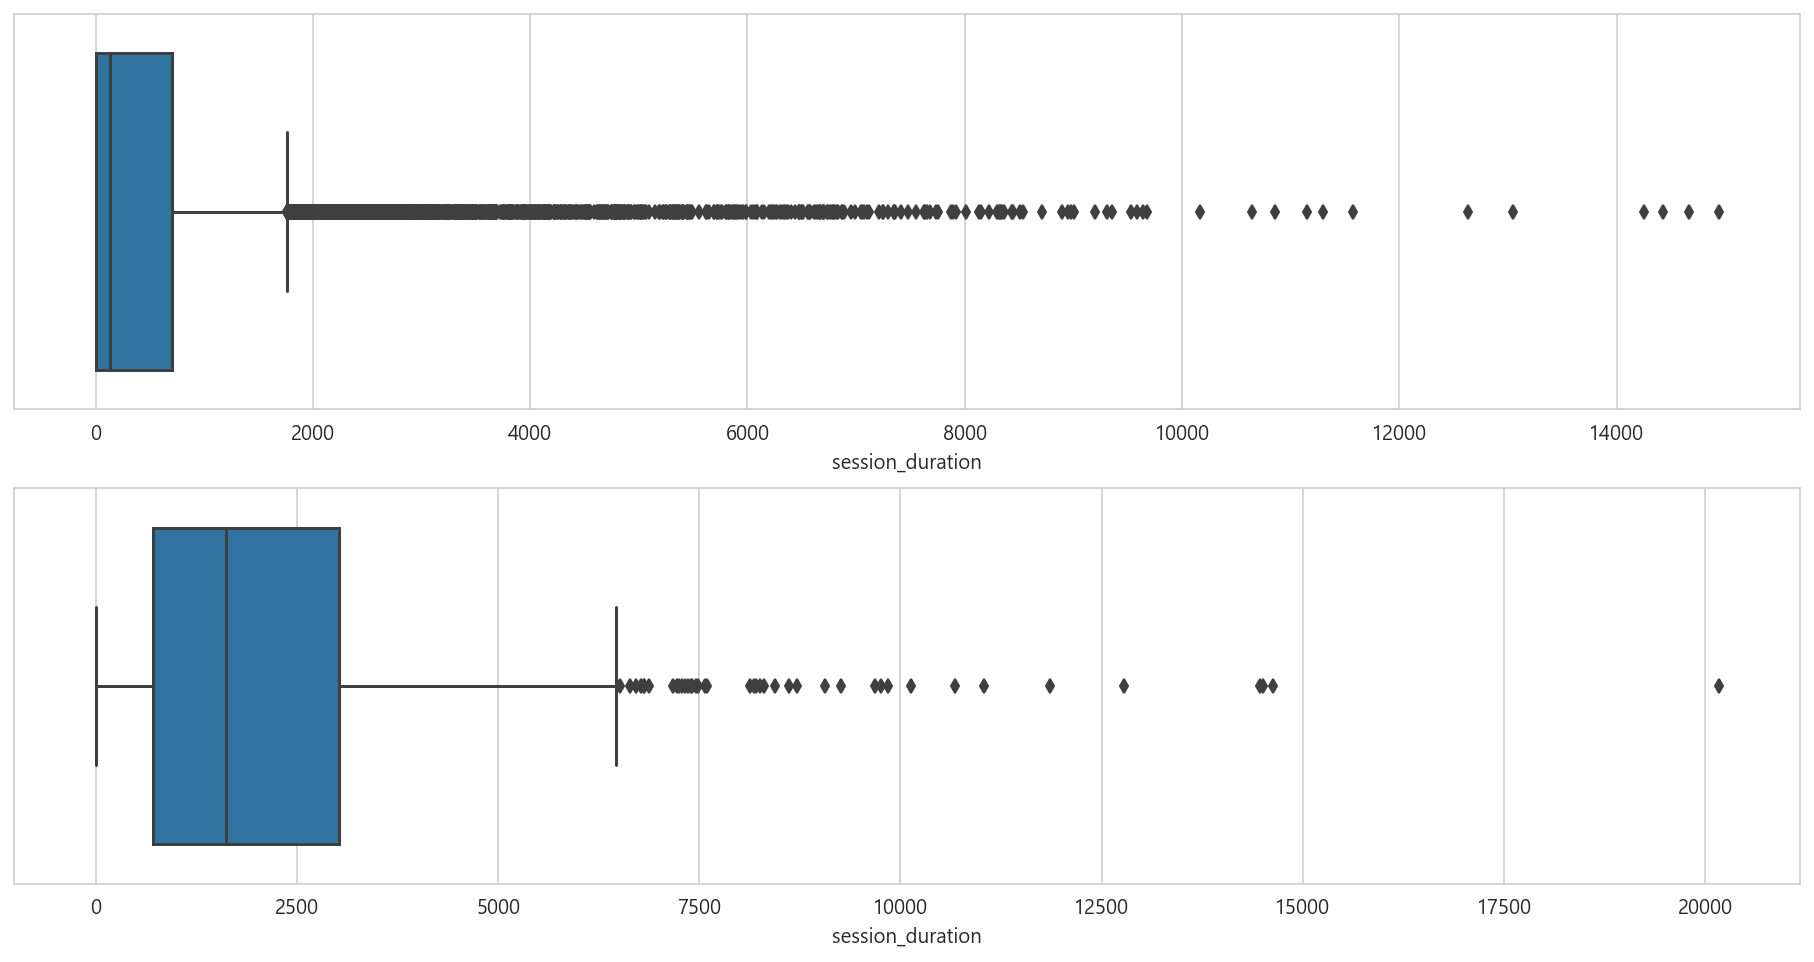

In [65]:
figure, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)

figure.set_size_inches(16,8)

sns.boxplot(data = npurchase_session_duration, x = "session_duration", ax = ax1)
sns.boxplot(data = purchase_session_duration, x = "session_duration", ax = ax2)

In [66]:
purchase_session_mean = purchase_session_duration['session_duration'].mean()
npurchase_session_mean = npurchase_session_duration['session_duration'].mean()

print("구매 session 잔존 시간 평균:",purchase_session_mean)
print("비구매 session 잔존 시간 평균:",npurchase_session_mean)

구매 session 잔존 시간 평균: 2280.0800799999997
비구매 session 잔존 시간 평균: 611.9902027010454
